In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [20]:
path = './proj1/segmented-train/11jeonghy/7/kdigits0-7.wav'
def time_domain_VAD(path, print=False):
    
    signal, Fs = librosa.load(path, sr = None)
    Tf = 0.02
    Ts = 0.01
    Nf = int(Fs * Tf)
    Ns = int(Fs * Ts)

    nframes = int(np.ceil(len(signal)/Ns))
    u = np.zeros(nframes)
    for i in range(nframes):
        u[i] = np.sum(np.power(signal[i*Ns:i*Ns+Nf],2))    

    threshold = np.mean(u)
    
    ux = u[u>threshold]
    un = u[u<=threshold]

    ux_var = np.var(ux)
    un_var = np.var(un)
    
    px = np.zeros(nframes)
    pn = np.zeros(nframes)
    
    def gaussian_probability(x, var):
        return np.exp(-x**2/(2*var))* (1/np.sqrt(2*np.pi*var))

    for i in range(nframes):
        px[i] = gaussian_probability(u[i], ux_var)
        pn[i] = gaussian_probability(u[i], un_var)
    
    pv = 0.5
    
    def compute_voice_conditional(pv, px, pn):
        return (pv*px)/(pv*px + (1-pv)*pn)

    for i in range(30):
        voice = compute_voice_conditional(pv, px, pn)
        
        pv = np.mean(voice)
        ux_var = np.sum(voice*np.power(u,2))/np.sum(voice)
        un_var = np.sum((1-voice)*np.power(u,2))/np.sum(1-voice)
        for j in range(nframes):
            px[j] = gaussian_probability(u[j], ux_var)
            pn[j] = gaussian_probability(u[j], un_var)
    
    hard = np.zeros(nframes)
    for i in range(nframes):
        if compute_voice_conditional(pv, px, pn)[i] >= 0.5:
            hard[i] = 1
        else: hard[i] = 0

    if print == True:
        plt.figure()
        plt.title('energy per frame')
        plt.plot(u)
        plt.figure()
        plt.title('hard decision result')
        plt.plot(hard)
    
    idx = np.argmax(u)
    idx_start = idx
    idx_end = idx
    
    while hard[idx_start] == 1:
        idx_start -= 1
    
    while hard[idx_end] == 1:
        idx_end -= 1
    
    print(idx_start, idx_end)
    
    original_idx_start = idx_start*Ns
    original_idx_end = idx_end*Ns+Nf
    
    speech = signal[original_idx_start:original_idx_end]
    noise = np.concatenate((signal[:original_idx_start], signal[original_idx_end:]))
    
    
    # fourier transform the noise
    noise_fft = np.fft.fft(noise)
    noise_energy = np.abs(noise_fft)**2
    print(noise_fft)
    
    
    '''    
    try: 
        idx = np.where(hard==1)[0]
        original_idx_start = idx[0]*Ns
        original_idx_end = idx[-1]*Ns+Nf
    except:
        return 0
    '''

In [18]:
time_domain_VAD(path)

TypeError: 'bool' object is not callable

8800 3200
[  0   8  16  24  32  40  48  56  64  72  80  88  96 104 112 120 128 136
 144 152 160 168 176 184 192 200 208 216 224 232 240 248 256]
(31,)
257


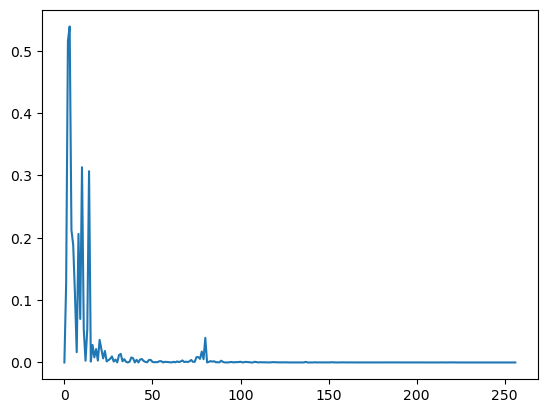

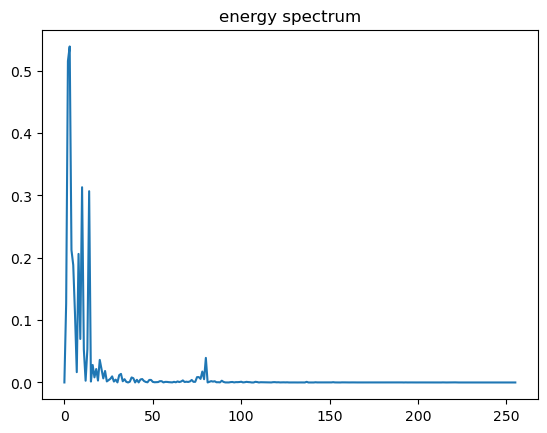

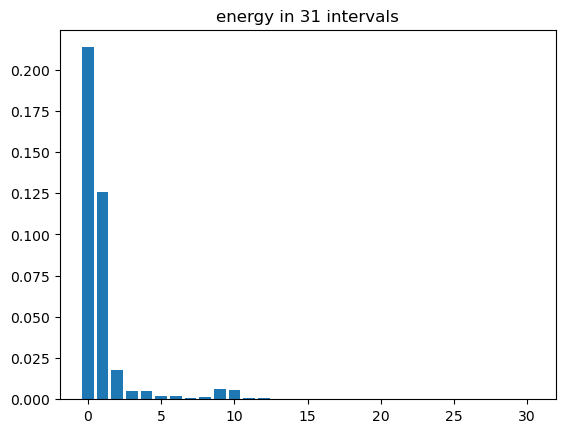

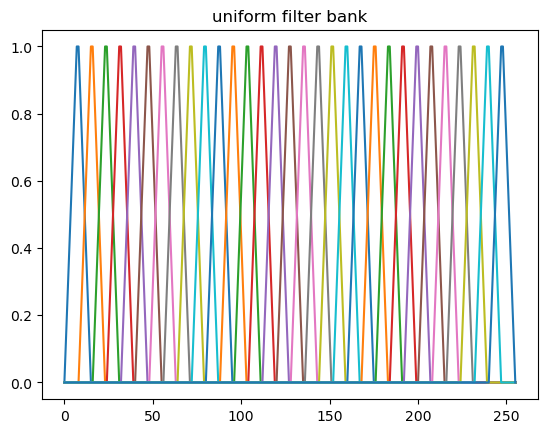

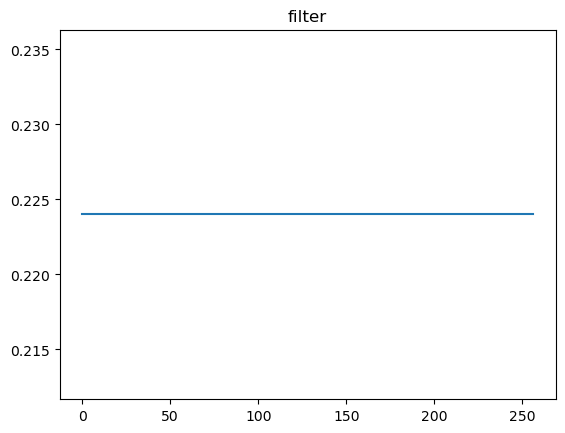

In [25]:
signal, Fs = librosa.load(path, sr = None)
Tf = 0.02
Ts = 0.01
Nf = int(Fs * Tf)
Ns = int(Fs * Ts)

ffts = np.fft.fft(signal, n=512)
ffts = np.abs(ffts)**2
plt.plot(ffts[:257])


nframes = int(np.ceil(len(signal)/Ns))
u = np.zeros(nframes)
for i in range(nframes):
    u[i] = np.sum(np.power(signal[i*Ns:i*Ns+Nf],2))    

threshold = np.mean(u)

ux = u[u>threshold]
un = u[u<=threshold]

ux_var = np.var(ux)
un_var = np.var(un)

px = np.zeros(nframes)
pn = np.zeros(nframes)

def gaussian_probability(x, var):
    return np.exp(-x**2/(2*var))* (1/np.sqrt(2*np.pi*var))

for i in range(nframes):
    px[i] = gaussian_probability(u[i], ux_var)
    pn[i] = gaussian_probability(u[i], un_var)

pv = 0.5

def compute_voice_conditional(pv, px, pn):
    return (pv*px)/(pv*px + (1-pv)*pn)

for i in range(30):
    voice = compute_voice_conditional(pv, px, pn)
    
    pv = np.mean(voice)
    ux_var = np.sum(voice*np.power(u,2))/np.sum(voice)
    un_var = np.sum((1-voice)*np.power(u,2))/np.sum(1-voice)
    for j in range(nframes):
        px[j] = gaussian_probability(u[j], ux_var)
        pn[j] = gaussian_probability(u[j], un_var)

hard = np.zeros(nframes)
for i in range(nframes):
    if compute_voice_conditional(pv, px, pn)[i] >= 0.5:
        hard[i] = 1
    else: hard[i] = 0

idx = np.where(hard==1)[0]
original_idx_start = idx[0]*Ns
original_idx_end = idx[-1]*Ns+Nf

speech = signal[original_idx_start:original_idx_end]
noise = np.concatenate((signal[:original_idx_start], signal[original_idx_end:]))
print(original_idx_end, original_idx_start)

NFFT = 512
noise_fft = np.fft.fft(noise, n=NFFT)
signal_fft = np.fft.fft(signal, n=NFFT)

noise_energy = np.abs(noise_fft)**2
signal_energy = np.abs(signal_fft)**2
plt.figure()
plt.title('energy spectrum')
plt.plot(signal_energy[:NFFT//2])
#plt.plot(noise_energy[:NFFT//2])

num_filters = 31
intervals = np.arange(0, NFFT/2+NFFT/64, NFFT/64, dtype=int)
energy = np.zeros(num_filters)
for i in range(num_filters):
    energy[i] = np.mean(signal_energy[intervals[i]:intervals[i+1]])
    
plt.figure()
plt.title('energy in %d intervals'%num_filters)
# plot energy as histogram
plt.bar(np.arange(num_filters), energy)

print(intervals)
fbank = np.zeros((num_filters, NFFT//2))
# make each row 0, 1/8, ..., 1, ..., 1/8, 0
for i in range(num_filters):
    fbank[i][intervals[i]:intervals[i+1]] = np.linspace(0,1,intervals[i+1]-intervals[i])
    try: fbank[i][intervals[i+1]:intervals[i+2]] = np.linspace(1,0,intervals[i+2]-intervals[i+1])
    except: pass

plt.figure()
plt.title('uniform filter bank')
for i in range(num_filters):
    plt.plot(fbank[i])

fbank_energy = np.matmul(fbank, signal_energy[:NFFT//2])
print(fbank_energy.shape)
noise_e = np.matmul(fbank.T, fbank_energy)

epsilon = 0.224
h = []
for i in range(NFFT//2+1):
    k = signal_energy[i]-noise_energy[i]
    k = k/signal_energy[i]
    h.append(max(epsilon, k))
print(len(h))
plt.figure()
plt.title('filter')
plt.plot(h)

(512,)
[0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j
 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j
 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j
 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j
 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j
 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j
 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j
 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j
 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j
 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j
 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j
 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j
 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j
 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j 0.224+0.j

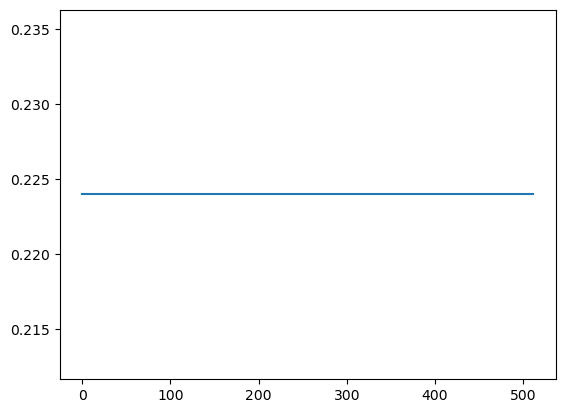

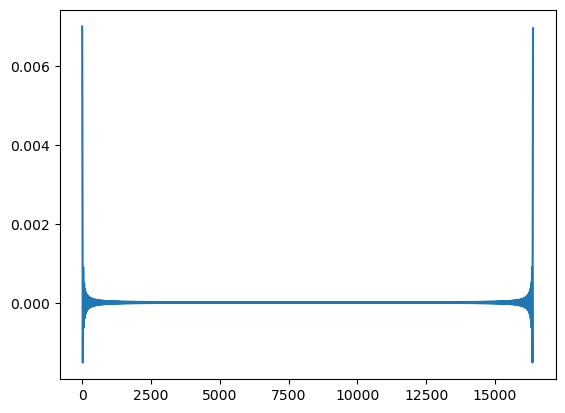

In [22]:
# concatenate h with its reverse.
# make the 
h = np.concatenate((h, h[-2:0:-1]))
h = h + 0j
print(h.shape)
print(h)
plt.figure()
plt.plot(h)
filter = np.fft.ifft(h, n=2**14)
print(filter)
plt.figure()
plt.plot(filter)

In [83]:
filtered = np.convolve(signal, filter, mode='same')

(16384,)


/Users/user/opt/anaconda3/envs/asr/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


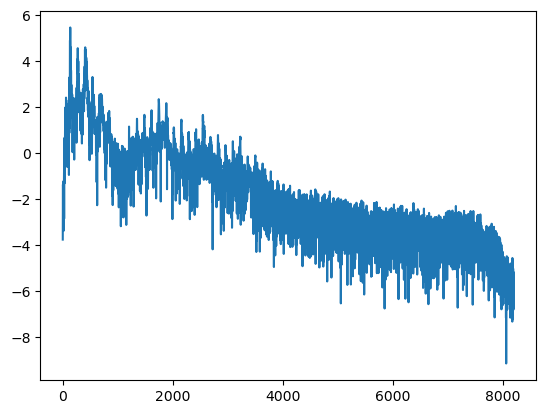

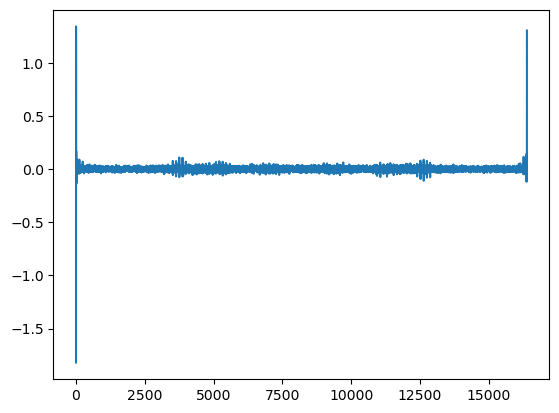

In [31]:
#find log fft_speech
fft_speech = np.fft.fft(signal, n=2**14)
plt.figure()
plt.plot(np.log(fft_speech)[:2**13+1])
log_fft_speech = np.log(fft_speech)
# apply ifft to log_fft_speech
ifft_log_fft_speech = np.fft.ifft(log_fft_speech)
plt.figure()
plt.plot(ifft_log_fft_speech)
print(ifft_log_fft_speech.shape)